<a href="https://colab.research.google.com/github/L-Gaysina/Data_analytics/blob/main/tennis_analysis/Tennis_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ матчей ATP
Выполнила Гайсина Лиана Ильдаровна


>Задача — проверить, как изменился мир тенниса за последнее время. Для анализа используйте только данные из одиночного разряда (файлы в формате «atp_matches_YYYY.csv»). Желательно сопровождать выбранный статистический тест ссылкой на его документацию и указывать нулевую гипотезу, которую этот тест проверяет.

In [ ]:
# @title Импорт библиотек
import requests
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

# Предобработка данных

In [ ]:
# Подключение к гугл диску
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Создаем директорию на Google Диске, если ее еще не существует
save_directory = '/content/drive/MyDrive/Data_Analytics/HW2/data/'

if not os.path.exists(save_directory):
    os.makedirs(save_directory)
    print(f"Директория {save_directory} успешно создана.")
else:
    print(f"Директория {save_directory} уже существует.")

Директория /content/drive/MyDrive/Data_Analytics/HW2/data/ уже существует.


In [ ]:
# @title Загрузка файлов с репозитория

# URL GitHub репозитория
url = 'https://github.com/JeffSackmann/tennis_atp/blob/master/'

# Отправляем GET-запрос по указанному URL
response = requests.get(url)

# Парсим HTML-содержимое страницы
soup = BeautifulSoup(response.content, 'html.parser')

# Находим все ссылки на странице
links = soup.find_all('a')

# Список для хранения имен сsv файлов
saved_files_list = []

# Проходим по всем ссылкам, чтобы найти CSV-файлы в формате 'atp_matches_YYYY.csv' и загрузить их
for link in links:
    href = link.get('href')
    if href and href.endswith('.csv') and 'atp_matches_' in href:
        file_name = href.split('/')[-1]
        if file_name.startswith('atp_matches_') and len(file_name) == 20:
            file_url = 'https://raw.githubusercontent.com' + href.replace('/blob', '').replace(' ', '%20')
            file_path = os.path.join(save_directory, file_name)

            # Читаем данные CSV и сохраняем их в файл
            df = pd.read_csv(file_url)
            df.to_csv(file_path, index=False)

            # Сохраняем имя файла в список
            saved_files_list.append(save_directory + file_name)

print(f'Список скачанных файлов: {saved_files_list}')

Список скачанных файлов: ['/content/drive/MyDrive/Data_Analytics/HW2/data/atp_matches_1968.csv', '/content/drive/MyDrive/Data_Analytics/HW2/data/atp_matches_1968.csv', '/content/drive/MyDrive/Data_Analytics/HW2/data/atp_matches_1969.csv', '/content/drive/MyDrive/Data_Analytics/HW2/data/atp_matches_1969.csv', '/content/drive/MyDrive/Data_Analytics/HW2/data/atp_matches_1970.csv', '/content/drive/MyDrive/Data_Analytics/HW2/data/atp_matches_1970.csv', '/content/drive/MyDrive/Data_Analytics/HW2/data/atp_matches_1971.csv', '/content/drive/MyDrive/Data_Analytics/HW2/data/atp_matches_1971.csv', '/content/drive/MyDrive/Data_Analytics/HW2/data/atp_matches_1972.csv', '/content/drive/MyDrive/Data_Analytics/HW2/data/atp_matches_1972.csv', '/content/drive/MyDrive/Data_Analytics/HW2/data/atp_matches_1973.csv', '/content/drive/MyDrive/Data_Analytics/HW2/data/atp_matches_1973.csv', '/content/drive/MyDrive/Data_Analytics/HW2/data/atp_matches_1974.csv', '/content/drive/MyDrive/Data_Analytics/HW2/data/atp

In [ ]:
# @title Объединяем данные в один датафрейм

merged_data = pd.DataFrame()
for file in os.listdir(save_directory):
    file_path = os.path.join(save_directory, file)
    data = pd.read_csv(file_path)
    merged_data = pd.concat([merged_data, data], ignore_index=True)

In [ ]:
merged_data.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,1973-2016,London,Carpet,32.0,A,19731117,1,100119,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,88.0,NaN
1,1973-2016,London,Carpet,32.0,A,19731117,2,100304,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,193.0,NaN,71.0,NaN
2,1973-2016,London,Carpet,32.0,A,19731117,3,100135,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,39.0,NaN,118.0,NaN
3,1973-2016,London,Carpet,32.0,A,19731117,4,100121,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,42.0,NaN,135.0,NaN
4,1973-2016,London,Carpet,32.0,A,19731117,5,100284,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,11.0,NaN


# Описание признаков

`tourney_id` - уникальный идентификатор для каждого турнира. Первые 4 цифры - год

`tourney_name` - название турнира

`surface` - тип покрытия

`draw_size` - количество игроков в сетке, часто округленное до ближайшей степени двойки. (Например, турнир с 28 игроками может быть показан как 32.)

`tourney_level`

Для мужчин:
* 'G' = Большие шлемы,
* 'M' = Мастерс 1000,
* 'A' = другие турниры уровня тура,
* 'C' = Челленджеры,
* 'S' = Спутники/ITF,
* 'F' = Финалы тура и другие сезонные события,
* 'D' = Кубок Дэвиса

Для женщин существует несколько дополнительных кодов уровня турнира, включая
* 'P' = Премьер,
* 'PM' = Премьер-мандатори,
* 'I' = Интернациональный.

Различные уровни ITF определяются призовыми (в тысячах), например,
* '15' = ITF $15,000.
Другие коды, такие как
* 'T1' для Тир I (и так далее), используются для старых обозначений турниров WTA.
* 'D' используется для Кубка Федерации/Fed/Billie Jean King Cup, а также для кубка Уайтмана и кубка Бонне Белл.

`tourney_date` - восемь цифр, ГГГГММДД,

`match_num` - идентификатор матча.

`winner_id` , `loser_id`  - идентификатор игрока, используемый в этом репозитории для победителя/ проигравшего.

`winner_seed` , `loser_seed` - seed победителя/ проигравшего.

Seed в теннисе - это заранее определенное место в сетке соревнований, которое присваивается одному из участников на основе их рейтинга или прошлых результатов.

`winner_name`, `loser_name`- имя победителя/ проигравшего

`winner_hand`, `loser_hand` - рука подачи
* R = правая,
* L = левая,
* U = неизвестно. Для амбидекстров это их рука подачи.

`winner_ht`, `loser_ht` - рост в сантиметрах.

`winner_ioc`, `loser_ioc` - трехсимвольный код страны.

`winner_age`, `loser_age` - возраст

`score` - счет

`best_of` -

`round` -

`minutes` -

`w_ace`, `l_ace`  - количество подач-асов.

`w_df`, `l_df` - количество двойных ошибок.

`w_svpt`, `l_svpt` - количество подач.

`w_1stIn`, `l_1stIn` - количество первых подач, сделанных победителем/ проигравшим.

`w_1stWon`, `l_1stWon` - количество выигранных очков первой подачи победителя/ проигравшего.

`w_2ndWon`, `l_2ndWon` - количество выигранных очков второй подачи победителя/ проигравшего.

`w_SvGms`, `l_SvGms` - количество подач победителя / проиграпвшего.

`w_bpSaved`, `l_bpSaved` - количество спасенных брейк-пойнтов победителя / проигравшего.

`w_bpFaced`, `l_bpFaced`- количество столкнувшихся с брейк-пойнтами победителя / проигравшего.




`winner_rank` , `loser_rank` - рейтинг ATP или WTA, на дату турнира или наиболее актуальная дата рейтинга перед датой турнира

`winner_rank_points`, `loser_rank_points` -  количество рейтинговых очков, где доступно.

In [ ]:
# Создаем новый столбец 'year' с первыми 4 цифрами из 'tourney_id'
merged_data['year'] = merged_data['tourney_id'].apply(lambda x: int(str(x)[:4]))

# Удаляем столбец 'tourney_id'
merged_data.drop('tourney_id', axis=1, inplace=True)

In [ ]:
merged_data.head()

,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
0,London,Carpet,32.0,A,19731117,1,100119,NaN,NaN,Ilie Nastase,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,88.0,NaN,1973
1,London,Carpet,32.0,A,19731117,2,100304,NaN,NaN,Robert Kreiss,...,NaN,NaN,NaN,NaN,NaN,193.0,NaN,71.0,NaN,1973
2,London,Carpet,32.0,A,19731117,3,100135,NaN,NaN,Onny Parun,...,NaN,NaN,NaN,NaN,NaN,39.0,NaN,118.0,NaN,1973
3,London,Carpet,32.0,A,19731117,4,100121,NaN,NaN,Raymond Moore,...,NaN,NaN,NaN,NaN,NaN,42.0,NaN,135.0,NaN,1973
4,London,Carpet,32.0,A,19731117,5,100284,NaN,NaN,Jimmy Connors,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,11.0,NaN,1973


In [ ]:
# Сохраняем данные в файл csv
merged_data.to_csv(save_directory[:-5]+'merged_data.csv', index=False)
merged_data = pd.read_csv(save_directory[:-5]+'merged_data.csv')

In [ ]:
# Считываем данные из файла csv
save_directory = '/content/drive/MyDrive/Data_Analytics/HW2/data/'
merged_data = pd.read_csv(save_directory[:-5]+'merged_data.csv')
merged_data.head()

,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
0,London,Carpet,32.0,A,19731117,1,100119,NaN,NaN,Ilie Nastase,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,88.0,NaN,1973
1,London,Carpet,32.0,A,19731117,2,100304,NaN,NaN,Robert Kreiss,...,NaN,NaN,NaN,NaN,NaN,193.0,NaN,71.0,NaN,1973
2,London,Carpet,32.0,A,19731117,3,100135,NaN,NaN,Onny Parun,...,NaN,NaN,NaN,NaN,NaN,39.0,NaN,118.0,NaN,1973
3,London,Carpet,32.0,A,19731117,4,100121,NaN,NaN,Raymond Moore,...,NaN,NaN,NaN,NaN,NaN,42.0,NaN,135.0,NaN,1973
4,London,Carpet,32.0,A,19731117,5,100284,NaN,NaN,Jimmy Connors,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,11.0,NaN,1973


In [ ]:
# @title Проверяем наличие дубликатов в данных.

def find_duplicates(data):
    duplicates = data[data.duplicated(keep=False)]
    num_duplicates = duplicates.shape[0]

    if num_duplicates == 0:
        print('Дубликаты не найдены')
    else:
        print(f'Число явных дублей: {num_duplicates}')

    return duplicates

# Пример использования функции
data_duplicates = find_duplicates(merged_data)

Дубликаты не найдены


In [ ]:
# @title Проверяем наличие неинформативных признаков в данных.

def check_low_information_cols(data):
    low_information_cols = []

    for col in data.columns:
        top_freq = data[col].value_counts(normalize=True).max()
        nunique_ratio = data[col].nunique() / data[col].count()

        if top_freq > 0.95 or nunique_ratio > 0.95:
            low_information_cols.append(col)
            if top_freq > 0.95:
                print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
            if nunique_ratio > 0.95:
                print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

    if not low_information_cols:
        print("В данных нет неинформативных признаков.")
    return low_information_cols

# Пример использования функции
low_info_cols = check_low_information_cols(merged_data)

В данных нет неинформативных признаков.


<ipython-input-277-88250762b986>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=90)


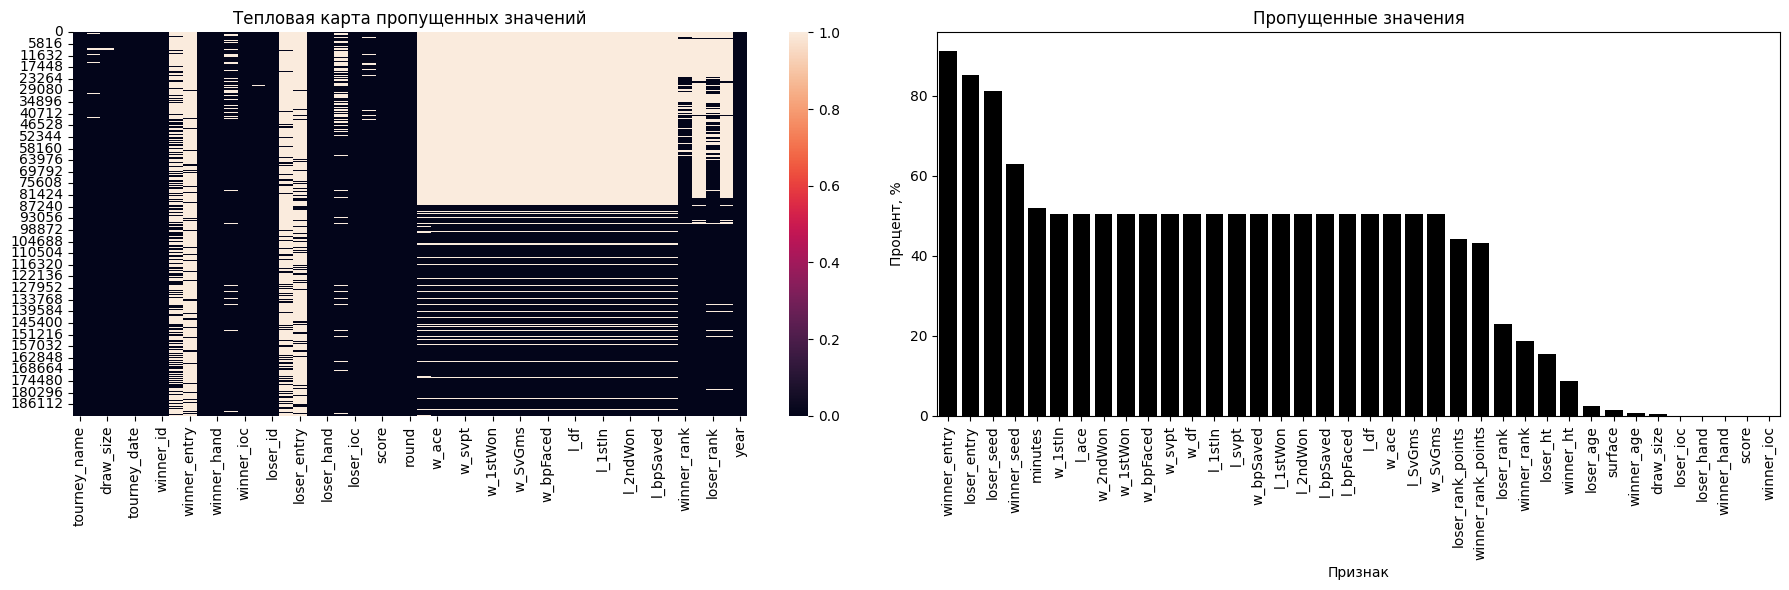

In [ ]:
# @title Провеяем наличие пропусков в данных.

def check_missing_values(data):
    cols_null_percent = data.isnull().mean() * 100
    cols_with_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)

    if cols_with_null.empty:
        print("Пропущенных значений нет.")
    else:
        fig, axes = plt.subplots(1, 2, figsize=(18, 6))

        # Карта пропусков
        sns.heatmap(data.isnull(), ax=axes[0])
        axes[0].set_title('Тепловая карта пропущенных значений')

        # Гистограмма процента пропусков в каждой колонке
        bar_plot = sns.barplot(x=cols_with_null.index, y=cols_with_null.values, ax=axes[1], color='black')
        bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=90)
        axes[1].set_ylabel('Процент, %')
        axes[1].set_xlabel('Признак')
        axes[1].set_title('Пропущенные значения')

        plt.tight_layout()
        plt.show()

# Пример использования функции
check_missing_values(merged_data)

In [ ]:
# Удаляем признаки с более 60% пропусков
combine_data = merged_data.copy()
n = combine_data.shape[0]
thresh = n * 0.4
combine_data = combine_data.dropna(thresh=thresh, axis=1)

<ipython-input-277-88250762b986>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=90)


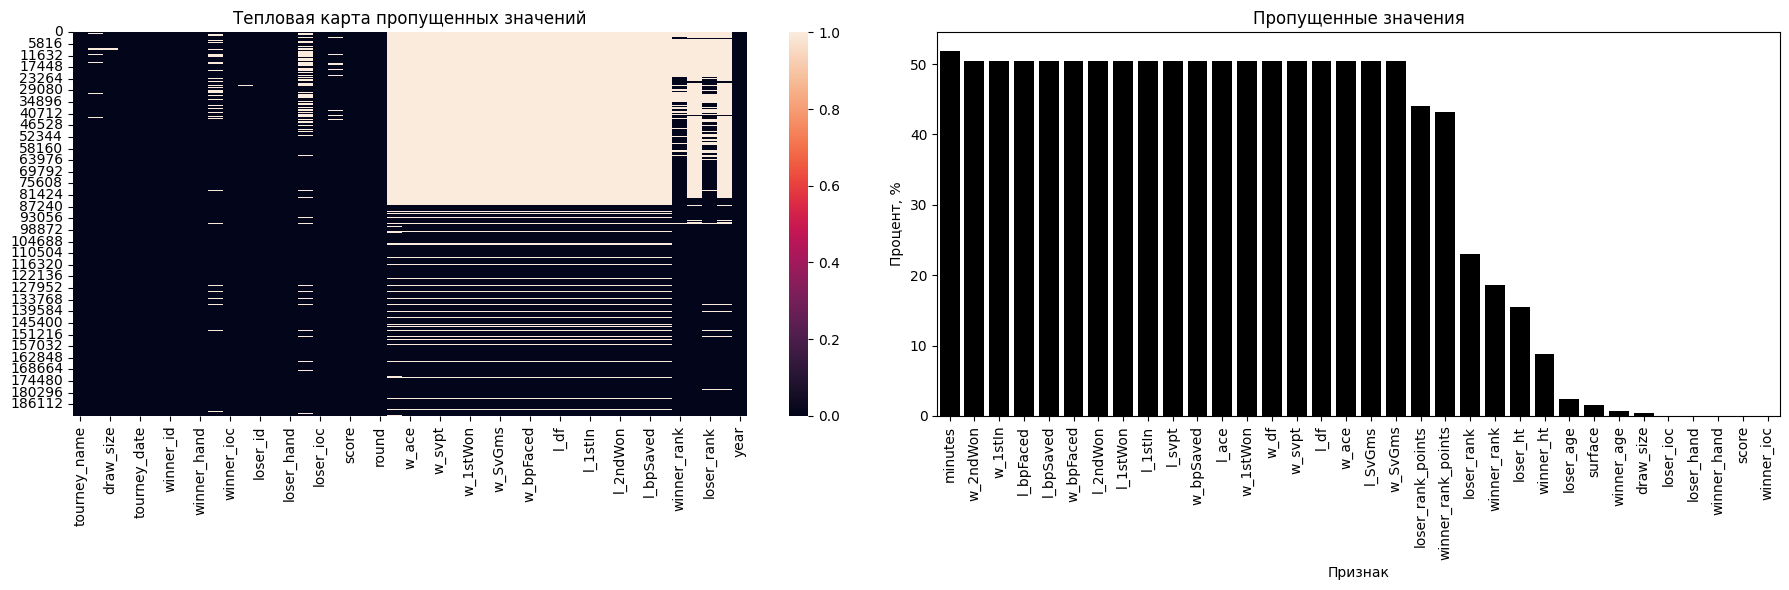

In [ ]:
# Проверяем оставшиеся пропуски
check_missing_values(combine_data)

In [ ]:
'''
#обрабатываем пропуски в категориальных признаках. замена на  unknown
combine_data['surface'] = combine_data['surface'].fillna('unknown')
combine_data['loser_ioc'] = combine_data['loser_ioc'].fillna('unknown')
combine_data['loser_hand'] = combine_data['loser_hand'].fillna('U')
combine_data['winner_hand'] = combine_data['winner_hand'].fillna('U')
combine_data['score'] = combine_data['score'].fillna('unknown')
combine_data['winner_ioc'] = combine_data['winner_ioc'].fillna('unknown')

#обрабатываем пропуски числовых признаков. замена на -1

combine_data['loser_rank'] = combine_data['loser_rank'].fillna(-1)
combine_data['winner_rank'] = combine_data['winner_rank'].fillna(-1)
combine_data['loser_ht'] = combine_data['loser_ht'].fillna(-1)
combine_data['winner_ht'] = combine_data['winner_ht'].fillna(-1)
combine_data['loser_age'] = combine_data['loser_age'].fillna(-1)
combine_data['winner_age'] = combine_data['winner_age'].fillna(-1)
combine_data['draw_size'] = combine_data['draw_size'].fillna(-1)
'''

# Задача 1.a


>Вы хотите узнать, как много значит ранг игрока в теннисе. Проверьте следующие утверждениe:

>Если ранг игрока выше более, чем на 20 позиций, то в среднем он будет выигрывать с большей вероятностью. (Если хотите проверить статистически — формируйте выборку как отклонение от ожидаемого количества побед при случайном исходе);

>Для выполнения данного задания можно использовать следующие шаги:

 * Сформировать две выборки игроков: первая выборка - игроки с рангом отличающимся более чем на 20 позиций от противника, вторая - игроки с близким рангом к противнику (отличие менее 20 позиций). Например:
`df_rank_1['higher_rank_win'] = (df_rank_1['winner_rank'] - df_rank_1['loser_rank']) > 20 `

 * Для каждой игры в выборках посчитать ожидаемое количество побед при случайном исходе. Это можно сделать, умножив количество сыгранных игр на вероятность выигрыша 0,5 (при равных шансах для каждого игрока).

 * Посчитать фактическое количество побед для каждого игрока в выборках.

 * Вычислить отклонение фактического количества побед от ожидаемого для каждого игрока.
 * ассчитать среднее отклонение для каждой выборки.
 * Сравнить средние отклонения между выборками.




## Решение


In [ ]:
# @title Создаем выборку игроков

# Удаляем строки с пропусками в рангах
data = combine_data.dropna(subset=['winner_rank', 'loser_rank', 'winner_id'], axis=0)

# Вычисляем разницу в рангах
rank_difference = abs(data['winner_rank'] - data['loser_rank'])
data = data.assign(rank_difference=rank_difference)

In [ ]:
data.head()

,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,winner_ht,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year,rank_difference
0,London,Carpet,32.0,A,19731117,1,100119,Ilie Nastase,R,183.0,...,NaN,NaN,NaN,NaN,1.0,NaN,88.0,NaN,1973,87.0
1,London,Carpet,32.0,A,19731117,2,100304,Robert Kreiss,R,NaN,...,NaN,NaN,NaN,NaN,193.0,NaN,71.0,NaN,1973,122.0
2,London,Carpet,32.0,A,19731117,3,100135,Onny Parun,R,188.0,...,NaN,NaN,NaN,NaN,39.0,NaN,118.0,NaN,1973,79.0
3,London,Carpet,32.0,A,19731117,4,100121,Raymond Moore,R,183.0,...,NaN,NaN,NaN,NaN,42.0,NaN,135.0,NaN,1973,93.0
4,London,Carpet,32.0,A,19731117,5,100284,Jimmy Connors,L,178.0,...,NaN,NaN,NaN,NaN,4.0,NaN,11.0,NaN,1973,7.0


In [ ]:
# @title Создание выборки игроков с разницой рангов > 20
data_more_20 = data [[ 'year', 'winner_id', 'winner_rank', 'loser_id', 'loser_rank', 'rank_difference']]
data_more_20 = data_more_20.query('rank_difference > 20')

# Сортировка данных по разнице рангов в порядке возрастания
data_more_20 = data_more_20.sort_values(by='rank_difference', ascending = True)
print("Выборка игроков с разницей рангов > 20:")
data_more_20.head()

Выборка игроков с разницей рангов > 20:


,year,winner_id,winner_rank,loser_id,loser_rank,rank_difference
64559,1984,100579,31.0,101131,52.0,21.0
180292,2018,104312,51.0,106065,72.0,21.0
141779,2006,103163,26.0,104468,47.0,21.0
169685,2016,105575,89.0,104291,68.0,21.0
137703,2005,104755,56.0,103333,77.0,21.0


In [ ]:
# Проверяем полученную выборку
data_duplicates = find_duplicates(data_more_20)
low_info_cols = check_low_information_cols(data_more_20)
check_missing_values(data_more_20)

# Отображаем первые строки данных
display(data_more_20.head())

Число явных дублей: 648
В данных нет неинформативных признаков.
Пропущенных значений нет.


,year,winner_id,winner_rank,loser_id,loser_rank,rank_difference
64559,1984,100579,31.0,101131,52.0,21.0
180292,2018,104312,51.0,106065,72.0,21.0
141779,2006,103163,26.0,104468,47.0,21.0
169685,2016,105575,89.0,104291,68.0,21.0
137703,2005,104755,56.0,103333,77.0,21.0


In [ ]:
# Удаляем дублирующиеся строки
data_more_20 = data_more_20.drop_duplicates()

# Проверяем результат удаления
data_duplicates = find_duplicates(data_more_20)

Дубликаты не найдены


In [ ]:
# @title Создание выборки игроков с разницой рангов <= 20
data_less_20 = data [['year', 'winner_id', 'winner_rank', 'loser_id', 'loser_rank', 'rank_difference']]
data_less_20 = data_less_20.query('abs(winner_rank - loser_rank) <= 20')

# Сортировка данных по разнице рангов в порядке убывания
data_less_20 = data_less_20.sort_values(by='rank_difference', ascending = False)

print("Выборка игроков с разницей рангов <= 20:")
data_less_20.head()

Выборка игроков с разницей рангов <= 20:


,year,winner_id,winner_rank,loser_id,loser_rank,rank_difference
91574,1992,101381,24.0,101733,44.0,20.0
152567,2010,104571,42.0,103720,22.0,20.0
112273,1997,102257,23.0,102029,43.0,20.0
176099,2017,111202,55.0,126094,35.0,20.0
187173,2022,200000,9.0,200221,29.0,20.0


In [ ]:
# Проверяем полученную выборку
data_duplicates = find_duplicates(data_less_20)
low_info_cols = check_low_information_cols(data_less_20)
check_missing_values(data_less_20)

# Отображаем первые строки данных
display(data_less_20.head())

Число явных дублей: 875
В данных нет неинформативных признаков.
Пропущенных значений нет.


,year,winner_id,winner_rank,loser_id,loser_rank,rank_difference
91574,1992,101381,24.0,101733,44.0,20.0
152567,2010,104571,42.0,103720,22.0,20.0
112273,1997,102257,23.0,102029,43.0,20.0
176099,2017,111202,55.0,126094,35.0,20.0
187173,2022,200000,9.0,200221,29.0,20.0


In [ ]:
# Удаляем дублирующиеся строки
data_less_20 = data_less_20.drop_duplicates()

# Проверяем результат удаления
data_duplicates = find_duplicates(data_less_20)

Дубликаты не найдены


In [ ]:
# @title Расчет статистики

def calculate_player_stats(data):
    # Считаем количество побед и поражений
    number_of_wins = data['winner_id'].value_counts().reset_index()
    number_of_losses = data['loser_id'].value_counts().reset_index()
    number_of_wins.columns = ['id', 'number_of_wins']
    number_of_losses.columns = ['id', 'number_of_losses']

    # Добавляем количество побед в датафрейм
    player_data = pd.merge(number_of_wins, number_of_losses, on='id', how='outer').fillna(0).astype(int)

    # Рассчитываем общее количество игр и ожидаемое количество побед для каждого игрока
    player_data['all_games'] = player_data['number_of_wins'] + player_data['number_of_losses']
    player_data['expected_wins'] = player_data['all_games'] * 0.5

    # Рассчитываем отклонение количества побед от ожидаемого количества побед
    player_data['deviation'] = player_data['number_of_wins'] - player_data['expected_wins']

    return player_data

In [ ]:
# @title Расчет статистики для игроков с разницей рангов > 20
player_stats_more_20 = calculate_player_stats(data_more_20)

# Сортировка данных по отклонению в порядке убывания
player_stats_more_20 = player_stats_more_20.sort_values(by='deviation', ascending = False)

print("Статистика игроков с разницей рангов > 20:")
player_stats_more_20.head()

Статистика игроков с разницей рангов > 20:


,id,number_of_wins,number_of_losses,all_games,expected_wins,deviation
0,103819,811,103,914,457.0,354.0
1,104745,689,88,777,388.5,300.5
2,104925,653,73,726,363.0,290.0
3,100656,622,86,708,354.0,268.0
5,100284,584,91,675,337.5,246.5


In [ ]:
# @title Расчет статистики для игроков с разницей рангов <= 20

player_stats_less_20 = calculate_player_stats(data_less_20)

# Сортировка данных по отклонению в порядке убывания
player_stats_less_20 = player_stats_less_20.sort_values(by='deviation', ascending = False)

print("Статистика игроков с разницей рангов <= 20:")
player_stats_less_20.head()

Статистика игроков с разницей рангов <= 20:


,id,number_of_wins,number_of_losses,all_games,expected_wins,deviation
1,104925,394,124,518,259.0,135.0
0,103819,415,157,572,286.0,129.0
2,104745,345,127,472,236.0,109.0
3,100656,301,133,434,217.0,84.0
4,100284,260,117,377,188.5,71.5


In [ ]:
# @title Среднее отклонение для каждой выборки.

mean_deviation_more20 = player_stats_more_20['deviation'].abs().mean()
mean_deviation_less20 = player_stats_less_20['deviation'].abs().mean()

print(f'Среднее отклонение для выборки игроков c разницей рангов > 20: {mean_deviation_more20:.2f}')
print(f'Среднее отклонение для выборки игроков c разницей рангов <= 20: {mean_deviation_less20:.2f}')

Среднее отклонение для выборки игроков c разницей рангов > 20: 7.19
Среднее отклонение для выборки игроков c разницей рангов <= 20: 2.92


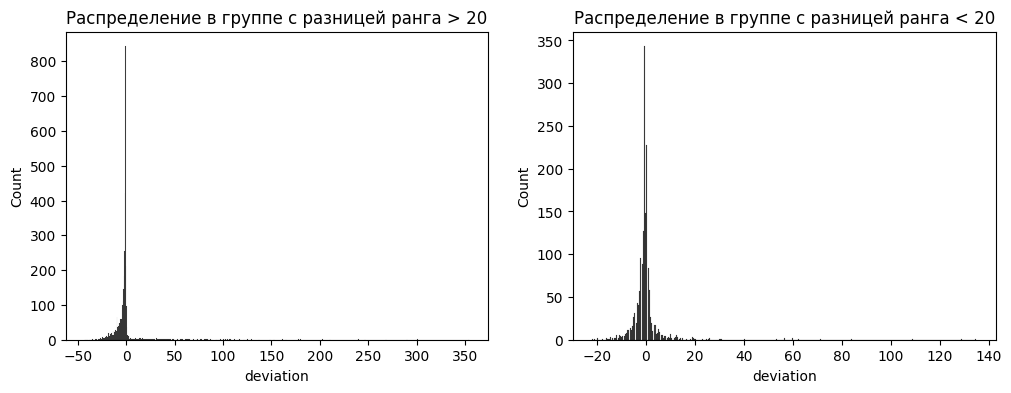

In [ ]:
# @title Построение графиков распределения отклонения фактического количества побед от ожидаемого

# Создаем графики распределения разницы в рангах для двух групп
plt.figure(figsize=(12, 4))

# Подграфик для группы с разницей ранга > 20
plt.subplot(1, 2, 1)
sns.histplot(x='deviation', data=player_stats_more_20, color='black')
plt.title('Распределение в группе с разницей ранга > 20')

# Подграфик для группы с разницей ранга < 20
plt.subplot(1, 2, 2)
sns.histplot(x='deviation', data=player_stats_less_20, color='black')
plt.title('Распределение в группе с разницей ранга < 20')

plt.show()

 ## Тест Шапиро-Уилка
Ссылка на документацию по тесту Шапиро-Уилка: [scipy.stats.shapiro](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)

Тест Шапиро-Уилка проверяет:

`H0` :  Данные в двух выборках соответсвуют нормальному распределению.

`H1` :  Данные соответсвуют распределению отличному от нормального.


In [ ]:
# @title Функция для проверки нормальности распределения (Тест Шапиро-Уилка)

def test_normality(data, a=0.05):
    statistic, p_value = shapiro(data)

    if p_value < a:
        interpretation = 'Отвергаем H0. Данные имеют распределение отличное от нормального'
    else:
        interpretation = 'Принимаем H0. Распределение данных соответсвуют нормальному'

    print(f'Статистика теста: {statistic:.4f}, \nP-value: {p_value:.4f},\n{interpretation}\n')

    return statistic, p_value, interpretation


# Пример использования функции
# statistic, p_value, interpretation = test_normality(player_stats_more_20)


In [ ]:
# @title Тест Шапиро-Уилка
print('Тест Шапиро-Уилка для выборки игроков с разницей рангов > 20')
statistic, p_value, interpretation = test_normality(player_stats_more_20)

print('Тест Шапиро-Уилка для выборки игроков с разницей рангов <= 20')
statistic, p_value, interpretation = test_normality(player_stats_less_20)


Тест Шапиро-Уилка для выборки игроков с разницей рангов > 20
Статистика теста: 0.4711, 
P-value: 0.0000,
Отвергаем H0. Данные имеют распределение отличное от нормального

Тест Шапиро-Уилка для выборки игроков с разницей рангов <= 20
Статистика теста: 0.4687, 
P-value: 0.0000,
Отвергаем H0. Данные имеют распределение отличное от нормального



/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


# Тест Манна-Уитни
Так как данные не распределены по нормальному закону, нужно испрользовать непараметрические статистические методы. Например, Тест Манна-Уитни  

 Ссылка на документацию: [scipy.stats.mannwhitneyu](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html)

`H0:` Ранг игрока не влияет на вероятность выигрыша и разница в вероятности выигрыша между игроками с рангами отличающимися более чем на 20 позиций случайна.

`H1:` Ранг игрока влияет на вероятность выигрыша и игроки с более высоким рангом (более чем на 20 позиций) имеют статистически значимо большую вероятность выигрыша.

In [ ]:
# Функция для проведения теста Манна-Уитни и вывода результатов

def run_mann_whitney_test(sample_a, sample_b, alpha=0.05):
    statistic, p_value = mannwhitneyu(sample_a, sample_b, alternative='greater')

    H0_hypothesis = 'Принимаем H0. Нет разницы между медианами двух выборок'
    H1_hypothesis = 'Отвергаем H0. Медиана первой выборки больше, чем медиана второй'

    result = {
        'Statistic': statistic,
        'P_value': p_value,
        'alpha': alpha
    }

    if p_value < alpha:

        print(f'P_value {p_value}')
        print('Отвергаем нулевую гипотезу H0.')
        print('Принимаем альтернативную гипотезу H1')

    else:
         print(f'P_value {p_value}')
         print('Принимаем нулевую гипотезу H0')




In [ ]:
# @title Тест Манна-Уитни
result = run_mann_whitney_test(player_stats_more_20['deviation'], player_stats_less_20['deviation'])

P_value 1.0
Принимаем нулевую гипотезу H0


## Выводы к задаче 1.а
* Результаты показывают, что среднее отклонение для выборки с разницей рангов
более чем на 20 позиций составляет 7.19, в то время как для выборки с разницей рангов менее 20 позиций - 2.92.

*  Однако, результаты теста Манна-Уитни при уровне значимости 0.05 не позволяют отвергнуть нулевую гипотезу о том, что различия в рангах более чем на 20 позиций не приводят к статистически значимым изменениям в вероятности победы.






# Задача 1.б
>Если ранг игрока находится в окне +-5 позиций, то вероятность победы будет значительно отличаться от гипотезы из предыдущего случая. Для проверки статистической значимости выборку можно сделать как среднее по годам (например, с 1980 по 2022г.). Подумайте, как правильно сформировать репрезентативную выборку.

>В данном случае для проверки статистической значимости гипотезы о том, что вероятность победы игроков с рангами, отличающимися не более чем на 5 позиций, будет значительно отличаться от предыдущего случая (ранги различаются более чем на 20 позиций), то есть надо сделать выборку в случае если ранг отличается на 5 позиций. Нужно сравнить среднее количество побед между двумя группами.

In [ ]:
# @title Создание выборки

# Удаляем строки с пропусками
data = combine_data.dropna(subset=['year', 'winner_id', 'winner_rank', 'loser_id', 'loser_rank'], axis=0)

# Вычисляем разницу в рангах
data = data.assign(rank_difference=abs(data['winner_rank'] - data['loser_rank']))

# Выбор только тех матчей, где разница в ранге игроков не превышает 5 позиций
data_less_5 = data[data['rank_difference'] <= 5]

# Группировка по 'winner_id', 'year'
number_of_wins = (data_less_5
                  .groupby(['winner_id', 'year'])
                  .size()
                  .reset_index(name='number_of_wins'))

# Считаем среднее количество побед
data_less_5 = number_of_wins.groupby(['year'])['number_of_wins'].mean().reset_index()

# Сортировка данных по разнице в порядке убывания
data_less_5 = data_less_5.sort_values(by='number_of_wins', ascending=False)

data_less_5.head()

,year,number_of_wins
6,1979,3.015873
36,2009,2.869048
4,1977,2.861111
1,1974,2.802817
42,2015,2.647059


In [ ]:
# Проверяем полученную выборку
data_duplicates = find_duplicates(data_less_5)
low_info_cols = check_low_information_cols(data_less_5)
check_missing_values(data_less_5)

# Выводим на экран первые строки выборки
display(data_less_5.head())

Дубликаты не найдены
year: 100.0% уникальных значений
number_of_wins: 100.0% уникальных значений
Пропущенных значений нет.


,year,number_of_wins
6,1979,3.015873
36,2009,2.869048
4,1977,2.861111
1,1974,2.802817
42,2015,2.647059


In [ ]:
# @title Создание выборки игроков с рангами, отличающимися более чем на 5 позиций

# Выбор только тех матчей, где разница в ранге игроков превышает 5 позиций
data_more_5 = data[data['rank_difference'] > 5]

data_more_5 = data_more_5[['year', 'winner_id', 'winner_rank', 'loser_id', 'loser_rank', 'rank_difference']]

# Группировка по 'winner_id', 'year'
number_of_wins = (data_more_5
                  .groupby(['winner_id', 'year'])
                  .size()
                  .reset_index(name='number_of_wins'))

# Считаем среднее количество побед
data_more_5 = number_of_wins.groupby(['year'])['number_of_wins'].mean().reset_index()

# Сортировка данных по разнице в порядке убывания
data_more_5 = data_more_5.sort_values(by='number_of_wins', ascending=False)

data_more_5.head()

,year,number_of_wins
1,1974,13.840000
4,1977,12.923077
2,1975,12.535545
8,1981,12.070796
6,1979,11.869231


In [ ]:
# Проверяем полученную выборку
data_duplicates = find_duplicates(data_more_5)
low_info_cols = check_low_information_cols(data_more_5)
check_missing_values(data_more_5)

# Выводим на экран первые строки выборки
display(data_more_5.head())

Дубликаты не найдены
year: 100.0% уникальных значений
number_of_wins: 100.0% уникальных значений
Пропущенных значений нет.


,year,number_of_wins
1,1974,13.840000
4,1977,12.923077
2,1975,12.535545
8,1981,12.070796
6,1979,11.869231


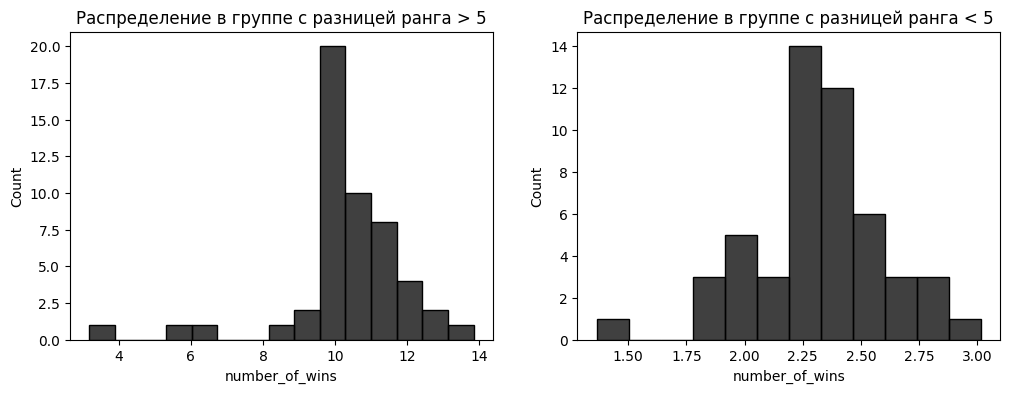

In [ ]:
#@title Построение графика распределения
plt.figure(figsize=(12, 4))

# Первый график Распределение в группе с разницей ранга > +-5
plt.subplot(1, 2, 1)
sns.histplot(x='number_of_wins', data=data_more_5, color='black')
plt.title('Распределение в группе с разницей ранга > 5')

# Второй график Распределение в группе с разницей ранга < +-5
plt.subplot(1, 2, 2)
sns.histplot(x='number_of_wins', data=data_less_5, color='black')
plt.title('Распределение в группе с разницей ранга < 5')

plt.show()

In [ ]:
# @title Среднее количество побед каждой выборки.

mean_more5 = data_more_5['number_of_wins'].mean()
mean_less5 = data_less_5['number_of_wins'].mean()

print(f'Среднее количество побед для выборки игроков c разницей рангов > +-5: {mean_more5:.2f}')
print(f'Среднее количество побед для выборки игроков c разницей рангов <= +-5: {mean_less5:.2f}')

Среднее количество побед для выборки игроков c разницей рангов > +-5: 10.34
Среднее количество побед для выборки игроков c разницей рангов <= +-5: 2.32


 ## Тест Шапиро-Уилка
Ссылка на документацию по тесту Шапиро-Уилка: [scipy.stats.shapiro](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)

Тест Шапиро-Уилка проверяет:

`H0` :  Данные в двух выборках соответсвуют нормальному распределению.

`H1` :  Данные соответсвуют распределению отличному от нормального.


In [ ]:
# @title Тест Шапиро-Уилка для выборки data_more_5
print('Тест Шапиро-Уилка для выборки игроков с разницей рангов > +-5')
statistic, p_value, interpretation = test_normality(data_more_5)

Тест Шапиро-Уилка для выборки игроков с разницей рангов > +-5
Статистика теста: 0.6438, 
P-value: 0.0000,
Отвергаем H0. Данные имеют распределение отличное от нормального



In [ ]:
# @title Тест Шапиро-Уилка для выборки data_less_5
print('Тест Шапиро-Уилка для выборки игроков с разницей рангов < +-5')
statistic, p_value, interpretation = test_normality(data_less_5)

Тест Шапиро-Уилка для выборки игроков с разницей рангов < +-5
Статистика теста: 0.6432, 
P-value: 0.0000,
Отвергаем H0. Данные имеют распределение отличное от нормального



# Тест Манна-Уитни
Так как данные не распределены по нормальному закону, нужно испрользовать непараметрические статистические методы. Например, Тест Манна-Уитни  

 Ссылка на документацию: [scipy.stats.mannwhitneyu](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html)

`H0`: При различиях в рангах (находящиеся в окне +-5 и находящиеся за пределом +-5) средняя вероятность не будет отличаться.

`H1`: Разница в рангах влияет на вероятность выигрыша и игроки с более высоким различием в рангах (находящимся за пределами окна +-5 позиций) имеют статистически значимо большую вероятность выигрыша.

In [ ]:
# @title Тест Манна-Уитни
result = run_mann_whitney_test(data_more_5['number_of_wins'], data_less_5['number_of_wins'])

P_value 1.6518407508330782e-18
Отвергаем нулевую гипотезу H0.
Принимаем альтернативную гипотезу H1


## Выводы к задаче 1.б
* Результаты показывают, что среднее количество побед для выборки игроков с разницей в ранге больше чем +-5 (10.34) значительно выше, чем для игроков с разницей в ранге не более чем +-5 (2.32). Это может подтверждать альтернативную гипотезу о том, что вероятность победы игроков с близкими рангами (не более чем +-5) выше, чем у игроков с более значительной разницей в рангах.



*  По результатам теста Манна-Уитни при уровне значимости 0.05 можно сделать вывод, что медиана в первой выборке больше, чем медиана во второй выборке. Это указывает на то, что среднее количество побед в первой группе (вероятность победы игроков с разницей в ранге более чем +-5) выше, чем во второй группе (вероятность победы игроков с разницей в ранге не более чем +-5).

# Задача 2

>Правда ли, что среднее количество сетов, которое необходимо любому игроку для победы в матче, сокращается со временем? Разбейте данные на две группы — с 1980 до 2001 гг. и 2002-2022 гг. Как изменилось среднее количество сетов, которое победитель затратил на игру? Является ли разница средних этих двух выборок статистически значимой? Выбор статистического теста обоснуйте.

>Можно разделить данные на две группы: 1980-2001 гг. и 2002-2022 гг. и сравнить средние значения для каждой группы. Количество сетов можно рассчитать, используя признак score Далее нужно собрать данные о количестве сетов, сыгранных победителями в матчах за период с 1980 по 2022 год. Разделить данные на две группы: 1980-2001 и 2002-2022.

In [ ]:
# @title Создание выборки

# Удаляем строки с пропусками
data = combine_data[['year', 'score']].dropna()

# Разделяем данные на две группы с 1980 до 2001 гг. и 2002-2022 гг
data_1980_2001 = data.query('year >= 1980 and year <= 2001')
data_2002_2022 = data.query('year >= 2002 and year <= 2022')

# Расчитываем количество сетов
data_1980_2001['sets_number'] = data_1980_2001['score'].apply(lambda x: x.count('-'))
data_2002_2022['sets_number'] = data_2002_2022['score'].apply(lambda x: x.count('-'))

<ipython-input-325-12a318fec469>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1980_2001['sets_number'] = data_1980_2001['score'].apply(lambda x: x.count('-'))
<ipython-input-325-12a318fec469>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2002_2022['sets_number'] = data_2002_2022['score'].apply(lambda x: x.count('-'))


In [ ]:
# Проверяем полученную выборку data_1980_2001
data_duplicates = find_duplicates(data_1980_2001)
low_info_cols = check_low_information_cols(data_1980_2001)
check_missing_values(data_1980_2001)

# Выводим на экран первые строки выборки
display(data_1980_2001.head())

Число явных дублей: 61109
В данных нет неинформативных признаков.
Пропущенных значений нет.


,year,score,sets_number
46707,1980,6-2 6-3,2
46708,1980,7-6 6-3,2
46709,1980,6-1 5-7 6-1,3
46710,1980,6-3 6-2,2
46711,1980,6-4 6-4,2


In [ ]:
'''
# Удаляем дублирующиеся строки
data_1980_2001 = data_1980_2001.drop_duplicates()

# Проверка после удаления
data_duplicates = find_duplicates(data_1980_2001)

Дубликаты не найдены


In [ ]:
# Проверяем полученную выборку data_2002_2022
data_duplicates = find_duplicates(data_2002_2022)
low_info_cols = check_low_information_cols(data_2002_2022)
check_missing_values(data_2002_2022)

# Выводим на экран первые строки выборки
display(data_2002_2022.head())

Число явных дублей: 42350
В данных нет неинформативных признаков.
Пропущенных значений нет.


,year,score,sets_number
126775,2002,6-3 7-6(4),2
126776,2002,6-1 6-1,2
126777,2002,6-2 6-2,2
126778,2002,7-6(5) 6-1,2
126779,2002,6-4 6-4,2


In [ ]:
'''
# Удаляем дублирующиеся строки
data_2002_2022 = data_2002_2022.drop_duplicates()

# Проверка после удаления
data_duplicates = find_duplicates(data_2002_2022)

Дубликаты не найдены


In [ ]:
# Посчитаем среднее значение количества сетов в периоды 1980-2001 и 2002-2022
mean_1980_2001 = data_1980_2001['sets_number'].mean()
mean_2002_2022 = data_2002_2022['sets_number'].mean()

# Выведем результат
print(f'Среднее количество сетов в период 1980-2001: {mean_1980_2001}')
print(f'Среднее количество сетов в период 2002-2022: {mean_2002_2022}')

Среднее количество сетов в период 1980-2001: 2.5955360711430857
Среднее количество сетов в период 2002-2022: 2.621872938753841


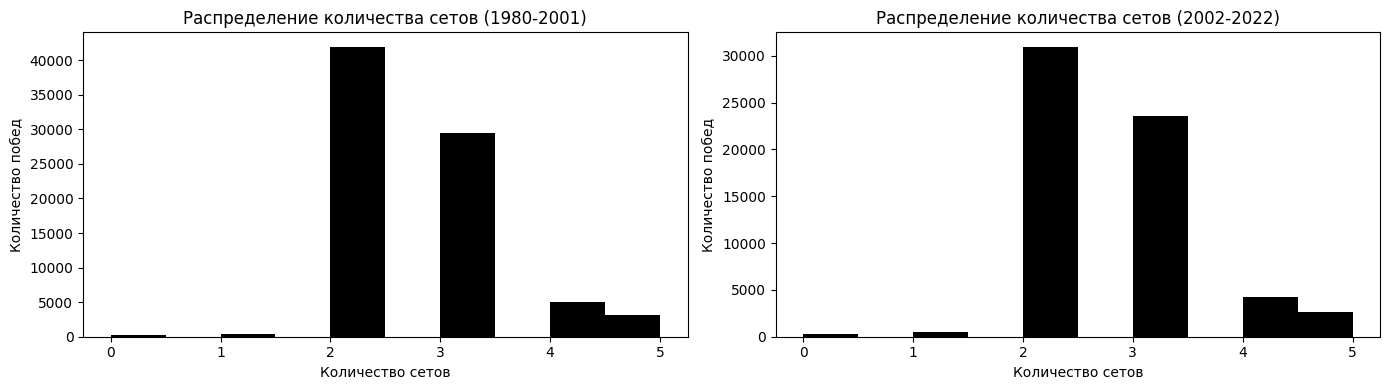

In [ ]:
#@title Построение графика распределения
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

# Построение гистограммы для данных с 1980 по 2001 год
axs[0].hist(data_1980_2001['sets_number'], color='black')
axs[0].set_title('Распределение количества сетов (1980-2001)')
axs[0].set_xlabel('Количество сетов')
axs[0].set_ylabel('Количество побед')

# Построение гистограммы для данных с 2002 по 2022 год
axs[1].hist(data_2002_2022['sets_number'], color='black')
axs[1].set_title('Распределение количества сетов (2002-2022)')
axs[1].set_xlabel('Количество сетов')
axs[1].set_ylabel('Количество побед')

plt.tight_layout()
plt.show()

 ## Тест Шапиро-Уилка
Ссылка на документацию по тесту Шапиро-Уилка: [scipy.stats.shapiro](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)

Тест Шапиро-Уилка проверяет:

`H0` :  Данные в двух выборках соответсвуют нормальному распределению.

`H1` :  Данные соответсвуют распределению отличному от нормального.

In [ ]:
# @title Тест Шапиро-Уилка для выборки data_1980_2001
print('Тест Шапиро-Уилка для выборки игроков с разницей рангов > +-5')
statistic, p_value, interpretation = test_normality(data_1980_2001['sets_number'])

Тест Шапиро-Уилка для выборки игроков с разницей рангов > +-5
Статистика теста: 0.7607, 
P-value: 0.0000,
Отвергаем H0. Данные имеют распределение отличное от нормального



/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
# @title Тест Шапиро-Уилка для выборки data_2002_2022
print('Тест Шапиро-Уилка для выборки игроков с разницей рангов > +-5')
statistic, p_value, interpretation = test_normality(data_2002_2022['sets_number'])

Тест Шапиро-Уилка для выборки игроков с разницей рангов > +-5
Статистика теста: 0.7855, 
P-value: 0.0000,
Отвергаем H0. Данные имеют распределение отличное от нормального



# Тест Манна-Уитни
Так как данные не распределены по нормальному закону, нужно испрользовать непараметрические статистические методы. Например, Тест Манна-Уитни  

 Ссылка на документацию: [scipy.stats.mannwhitneyu](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html)

`H0` :  Среднее количество сетов, необходимое для победы в матче, не меняется со временем.

`H1` :  Среднее количество сетов, необходимое для победы в матче, сокращается со временем.

In [ ]:
# @title Тест Манна-Уитни
result = run_mann_whitney_test(data_1980_2001['sets_number'], data_2002_2022['sets_number'])

P_value 0.9999999999992734
Принимаем нулевую гипотезу H0


## Вывод к задаче 2
После проведения статистического теста с уровнем значимости 0.05, получено высокое p-value равное 0.9999999999992734. Это говорит о том, что нет достаточных доказательств для отвержения нулевой гипотезы `H0`, которая утверждает, что среднее количество сетов, необходимое для победы в матче, не меняется со временем. Таким образом, на основании проведенного анализа, мы принимаем нулевую гипотезу и не можем сделать вывод о сокращении среднего количества сетов со временем.

#Задача 3

>У вас появились сомнения — не является ли результат, который вы посчитали на предыдущем шаге, некорректным. Кажется, что на это мог повлиять формат самого матча — best of 3 или best of 5. Оставьте только матчи best of 5 (колонка best_of) и определите — является ли разница среднего количества сетов, которое сыграл победитель, значимой для выборок матчей по 1980 до 2001 гг. и 2002-2022 гг. Выбор статистического теста обоснуйте.

In [ ]:
# @title Создание выборки

# Удаляем строки с пропусками
data = combine_data[['best_of','score', 'year']].dropna()

# Выбираем матчи best_of 5
data_best_of_5 = data[data['best_of'] == 5]

# Разделяем данные на две группы  с 1980 до 2001 гг. и 2002-2022 гг
data_best_of_5_1980_2001 = data_best_of_5.query('year >= 1980 and year <= 2001')
data_best_of_5_2002_2022 = data_best_of_5.query('year >= 2002 and year <= 2022')

# Расчитываем количество сетов
data_best_of_5_1980_2001['sets_number'] = data_best_of_5_1980_2001['score'].apply(lambda x: len(x.split()))
data_best_of_5_2002_2022['sets_number'] = data_best_of_5_2002_2022['score'].apply(lambda x: len(x.split()))

<ipython-input-333-5c7539352312>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_best_of_5_1980_2001['sets_number'] = data_best_of_5_1980_2001['score'].apply(lambda x: len(x.split()))
<ipython-input-333-5c7539352312>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_best_of_5_2002_2022['sets_number'] = data_best_of_5_2002_2022['score'].apply(lambda x: len(x.split()))


In [ ]:
# Проверяем полученную выборку data_best_of_5_1980_2001
data_duplicates = find_duplicates(data_best_of_5_1980_2001)
low_info_cols = check_low_information_cols(data_best_of_5_1980_2001)
check_missing_values(data_best_of_5_1980_2001)

# Выводим на экран первые строки выборки
display(data_best_of_5_1980_2001.head())

Число явных дублей: 5325
best_of: 100.0% одинаковых значений
Пропущенных значений нет.


,best_of,score,year,sets_number
46740,5,6-2 6-3 6-2,1980,3
46958,5,6-4 3-6 6-3 6-4,1980,4
46989,5,6-7 2-6 7-5 6-0 6-3,1980,5
47020,5,6-2 6-0 6-1,1980,3
47051,5,6-2 0-6 6-2 6-2,1980,4


In [ ]:
# Удаляем дублирующиеся строки
data_best_of_5_1980_2001 = data_best_of_5_1980_2001.drop_duplicates()
data_duplicates = find_duplicates(data_best_of_5_1980_2001)

Дубликаты не найдены


In [ ]:
# Проверяем полученную выборку data_best_of_5_2002_2022
data_duplicates = find_duplicates(data_best_of_5_2002_2022)
low_info_cols = check_low_information_cols(data_best_of_5_2002_2022)
check_missing_values(data_best_of_5_2002_2022)

# Выводим на экран первые строки выборки
display(data_best_of_5_2002_2022.head())

Число явных дублей: 4224
best_of: 100.0% одинаковых значений
Пропущенных значений нет.


,best_of,score,year,sets_number
127000,5,6-3 7-6(3) 7-6(3),2002,3
127140,5,6-4 6-1 6-3,2002,3
127171,5,6-3 3-6 3-6 6-4 6-4,2002,5
127233,5,6-4 6-3 6-2,2002,3
127350,5,6-4 6-1 3-6 6-4,2002,4


In [ ]:
# Удаляем дублирующиеся строки
data_best_of_5_2002_2022 = data_best_of_5_2002_2022.drop_duplicates()

# Проверяем
data_duplicates = find_duplicates(data_best_of_5_2002_2022)

Дубликаты не найдены


In [ ]:
# Посчитаем среднее значение количества сетов в периоды 1980-2001 и 2002-2022
mean_best_of_5_1980_2001 = data_best_of_5_1980_2001['sets_number'].mean()
mean_best_of_5_2002_2022 = data_best_of_5_2002_2022['sets_number'].mean()

# Выведем результат
print(f'Среднее количество сетов best_of_5 в период 1980-2001: {mean_best_of_5_1980_2001}')
print(f'Среднее количество best_of_5 сетов в период 2002-2022: {mean_best_of_5_2002_2022}')

Среднее количество сетов best_of_5 в период 1980-2001: 3.8700054949368083
Среднее количество best_of_5 сетов в период 2002-2022: 3.822114131850951


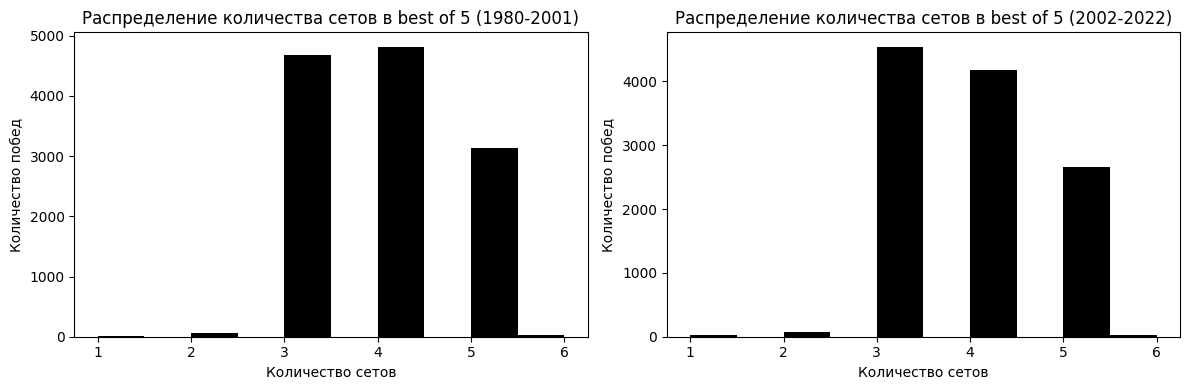

In [ ]:
# @title Построение графика распределения
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Построение гистограммы для данных с best of 5 матчами с 1980 по 2001 год
axs[0].hist(data_best_of_5_1980_2001['sets_number'], color='black')
axs[0].set_title('Распределение количества сетов в best of 5 (1980-2001)')
axs[0].set_xlabel('Количество сетов')
axs[0].set_ylabel('Количество побед')

# Построение гистограммы для данных с best of 5 матчами с 2002 по 2022 год
axs[1].hist(data_best_of_5_2002_2022['sets_number'], color='black')
axs[1].set_title('Распределение количества сетов в best of 5 (2002-2022)')
axs[1].set_xlabel('Количество сетов')
axs[1].set_ylabel('Количество побед')

plt.tight_layout()
plt.show()

 ## Тест Шапиро-Уилка
Ссылка на документацию по тесту Шапиро-Уилка: [scipy.stats.shapiro](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)

Тест Шапиро-Уилка проверяет:

`H0` :  Данные в двух выборках соответсвуют нормальному распределению.

`H1` :  Данные соответсвуют распределению отличному от нормального.

In [ ]:
# @title Тест Шапиро-Уилка для выборки data_best_of_5_1980_2001
print('Тест Шапиро-Уилка для выборки игроков с разницей рангов > +-5')
statistic, p_value, interpretation = test_normality(data_best_of_5_1980_2001['sets_number'])

Тест Шапиро-Уилка для выборки игроков с разницей рангов > +-5
Статистика теста: 0.8247, 
P-value: 0.0000,
Отвергаем H0. Данные имеют распределение отличное от нормального



/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
# @title Тест Шапиро-Уилка для выборки data_best_of_5_2002_2022
print('Тест Шапиро-Уилка для выборки игроков с разницей рангов > +-5')
statistic, p_value, interpretation = test_normality(data_best_of_5_2002_2022['sets_number'])

Тест Шапиро-Уилка для выборки игроков с разницей рангов > +-5
Статистика теста: 0.8249, 
P-value: 0.0000,
Отвергаем H0. Данные имеют распределение отличное от нормального



# Тест Манна-Уитни
Так как данные не распределены по нормальному закону, нужно испрользовать непараметрические статистические методы. Например, Тест Манна-Уитни  

 Ссылка на документацию: [scipy.stats.mannwhitneyu](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html)

`H0` :  Среднее количество сетов best_of_5, необходимое для победы в матче, не меняется со временем.

`H1` :  Среднее количество сетов best_of_5, необходимое для победы в матче, сокращается со временем.

In [ ]:
# @title Тест Манна-Уитни
result = run_mann_whitney_test(data_best_of_5_1980_2001['sets_number'], data_best_of_5_2002_2022['sets_number'])

P_value 1.4417353626396846e-06
Отвергаем нулевую гипотезу H0.
Принимаем альтернативную гипотезу H1


##Вывод к задаче 3
После проведения статистического теста с уровнем значимости 0.05, получено очень низкое значение p-value, равное 1.4417353626396846e-06. Это позволяет нам отвергнуть нулевую гипотезу H0, которая утверждает, что среднее количество сетов best_of_5, необходимое для победы в матче, не меняется со временем.

Таким образом, на основании проведенного анализа, у нас есть статистически значимые доказательства в пользу альтернативной гипотезы H1, которая гласит, что среднее количество сетов best_of_5, необходимое для победы в матче, сокращается со временем.

# Задача 4


>Вы хотите изучить психологическую устойчивость профессиональных игроков в теннис. Одним из важных показателей такой устойчивости будет доля выигранных брейк-поинтов. Возьмите трех игроков (они необязательно должны играть в одно и то же время. Можете взять игроков, которые сильно отличаются по рангу, а можете взять примерно равных игроков), для каждого из них посчитайте долю выигранных брейк поинтов (колонки, заканчивающиеся на bpFaced и bpSaved) отдельно в победных и проигранных матчах за минимум 10 лет (можно больше, но годы должны идти подряд). Постройте box-plot’ы для этих статистик для каждого из игроков. Являются ли эти распределения по годам (по победным и по проигранным матчам) независимыми для каждого из игроков? Если сравнивать эту статистику между игроками — будет ли разница в средних для проигранных и выигранных матчей значимой попарно между всеми игроками? Выбор статистического теста обоснуйте.

In [ ]:
# @title Создание выборки

# Удаляем строки с пропусками
data = combine_data[['winner_id', 'loser_id', 'w_bpSaved', 'w_bpFaced', 'l_bpSaved', 'l_bpFaced', 'year']].dropna()

top_players = (data
               .groupby('winner_id')['year']
               .count()
               .sort_values(ascending=False)
               )

# Выбираем игроков, которые играют более 10 лет подряд
players_with_10_years = []

for player_id in top_players.index:
    consecutive_years = (data[data['winner_id'] == player_id]['year'].unique())
    if len(consecutive_years) > 10:
        players_with_10_years.append(player_id)

players_with_10_years = [103819, 104925, 104745]

# Выберем только те игры, где участвуют интересующие нас игроки
data_win = data[data['winner_id'].isin(players_with_10_years[:3])][['year', 'winner_id',  'w_bpSaved', 'w_bpFaced']]
data_win = data_win.rename(columns={'winner_id': 'player_id', 'w_bpSaved': 'bpSaved', 'w_bpFaced': 'bpFaced'})

data_loss = data[data['loser_id'].isin(players_with_10_years[:3])][['year', 'loser_id', 'l_bpSaved', 'l_bpFaced']]
data_loss = data_loss.rename(columns={'loser_id': 'player_id', 'l_bpSaved': 'bpSaved', 'l_bpFaced': 'bpFaced'})

players_with_10_years = [103819, 104925, 104745]


In [ ]:
#@title Расчет доли выигранных брейк поинтов
# Посчитаем 'bpSaved' / 'bpFaced'  в выборке data_win
data_win ['bp_ratio_win'] = data_win ['bpSaved'] / data_win ['bpFaced']

# Посчитаем 'bpSaved' / 'bpFaced' в выборке data_loss
data_loss['bp_ratio_loss'] = data_loss['bpSaved'] / data_loss['bpFaced']

In [ ]:
# Выводим на экран первые строки выборки data_win
data_win.head()

,year,player_id,bpSaved,bpFaced,bp_ratio_win
116251,1998,103819,1.0,1.0,1.000
116260,1998,103819,4.0,4.0,1.000
117007,1999,103819,5.0,8.0,0.625
117023,1999,103819,3.0,5.0,0.600
117235,1999,103819,1.0,2.0,0.500


Число явных дублей: 2459
В данных нет неинформативных признаков.


<ipython-input-277-88250762b986>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=90)


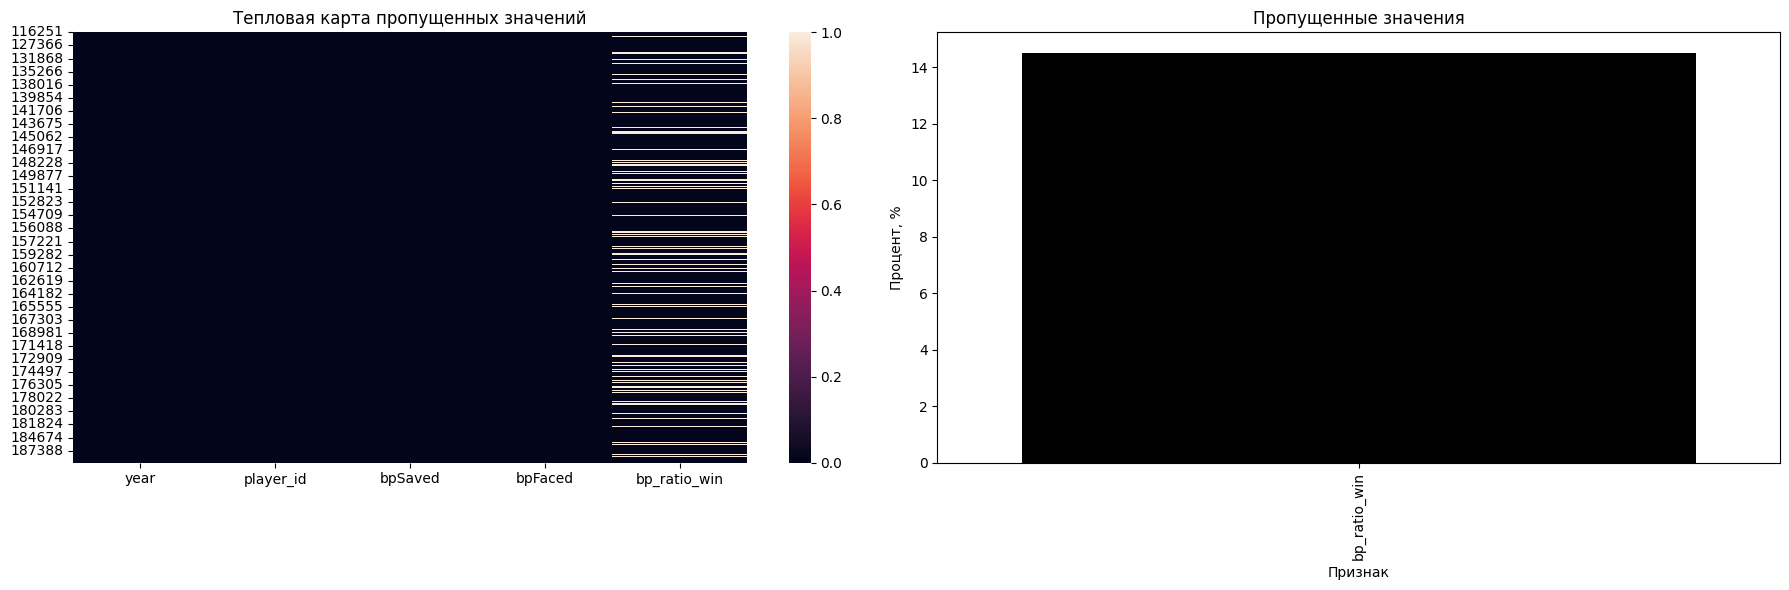

In [ ]:
# Проверяем полученную выборку data_win
data_duplicates = find_duplicates(data_win)
low_info_cols = check_low_information_cols(data_win)

# Проверяем
check_missing_values(data_win)

In [ ]:
# Заменим значение Nan, которое образовалось при делении на 0, на 0
data_win['bp_ratio_win'] = data_win['bp_ratio_win'].fillna(0)

# Проверим пропущенные значения
check_missing_values(data_win)

Пропущенных значений нет.


In [ ]:
# Удаляем дублирующиеся строки
data_win = data_win.drop_duplicates()

# Проверяем
data_duplicates = find_duplicates(data_win)

Дубликаты не найдены


In [ ]:
# Выводим на экран первые строки выборки data_loss
data_loss.head()

,year,player_id,bpSaved,bpFaced,bp_ratio_loss
115195,1998,103819,1.0,5.0,0.200
116265,1998,103819,7.0,10.0,0.700
116273,1998,103819,4.0,8.0,0.500
117031,1999,103819,5.0,10.0,0.500
117249,1999,103819,10.0,16.0,0.625


In [ ]:
# Проверяем полученную выборку data_loss
data_duplicates = find_duplicates(data_loss)
low_info_cols = check_low_information_cols(data_loss)

# Проверяем
check_missing_values(data_loss)

Число явных дублей: 108
В данных нет неинформативных признаков.
Пропущенных значений нет.


In [ ]:
# Удаляем дублирующиеся строки
data_loss = data_loss.drop_duplicates()

# Проверяем
data_duplicates = find_duplicates(data_loss)

Дубликаты не найдены


In [ ]:
#

winners_data = pd.DataFrame()
losers_data = pd.DataFrame()

for id in players_with_10_years:
    id_winners = data_win[(data_win['player_id'] == id)]
    id_losers = data_loss[(data_loss['player_id'] == id)]

    winners_grouped = id_winners.groupby('year').agg({'bp_ratio_win': 'mean'}).reset_index()
    winners_grouped['id'] = id
    winners_data = pd.concat([winners_data, winners_grouped], ignore_index=True)

    losers_grouped = id_losers.groupby('year').agg({'bp_ratio_loss': 'mean'}).reset_index()
    losers_grouped['id'] = id
    losers_data = pd.concat([losers_data, losers_grouped], ignore_index=True)

winners_data = winners_data.pivot_table(values='bp_ratio_win',
                       index='year',
                       columns='id',)

losers_data = losers_data.pivot_table(values='bp_ratio_loss',
                       index='year',
                       columns='id',)


In [ ]:
winners_data.head(20)

id,103819,104745,104925
year,,,
1998,1.000000,NaN,NaN
1999,0.479762,NaN,NaN
2000,0.647918,NaN,NaN
2001,0.712209,NaN,NaN
2002,0.620497,0.666667,NaN
2003,0.654077,0.668019,NaN
2004,0.660998,0.558389,0.400000
2005,0.647639,0.637864,0.595503
2006,0.659093,0.688689,0.608454


In [ ]:
# Объединяем полученные данные
data_combined = pd.concat([winners_data, losers_data], keys=['winners', 'losers'], axis = 1)

# Выводим результат
data_combined.head()

winners                     losers                 
id      103819    104745 104925    103819    104745 104925
year                                                      
1998  1.000000       NaN    NaN  0.466667       NaN    NaN
1999  0.479762       NaN    NaN  0.565124       NaN    NaN
2000  0.647918       NaN    NaN  0.563579       NaN    NaN
2001  0.712209       NaN    NaN  0.509816       NaN    NaN
2002  0.620497  0.666667    NaN  0.555274  0.555556    NaN

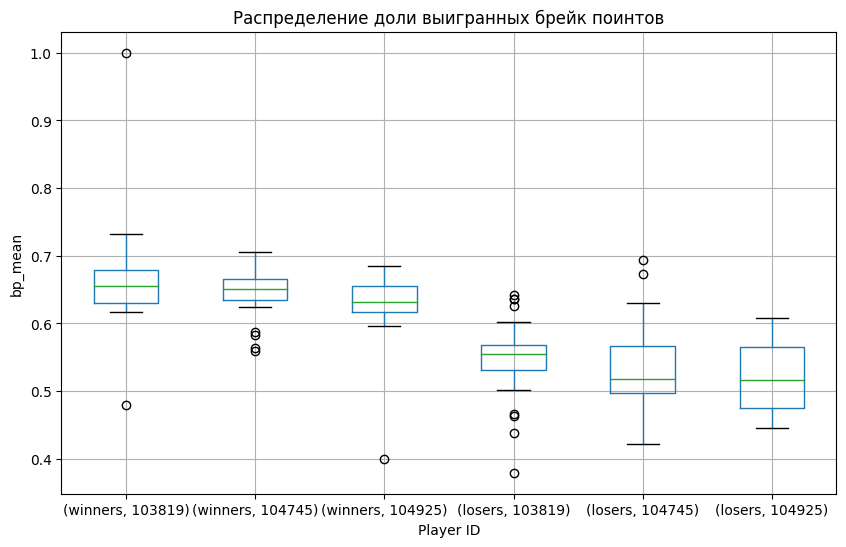

In [ ]:
#@title Построим график распределения

plt.figure(figsize=(10, 6))
data_combined.boxplot()
plt.title('Распределение доли выигранных брейк поинтов')
plt.ylabel('bp_mean')
plt.xlabel("Player ID")
plt.show()

## Тест хи-квадрат
тест хи-квадрат предназначен для проверки наличия статистической связи между двумя категориальными переменными. Он используется для определения, насколько сильно переменные связаны между собой.

Применение теста хи-квадрат может быть обосновано в следующих случаях:
1. Когда у нас есть две категориальные переменные и мы хотим определить, существует ли статистическая связь между ними.
2. Когда нам нужно определить, насколько наблюдаемые частоты отличаются от ожидаемых частот в случае отсутствия связи между переменными.

Использование теста хи-квадрат позволяет оценить статистическую значимость связи между переменными и проверить гипотезу о их независимости. Таким образом, данный тест может быть полезен для анализа взаимосвязи между двумя категориальными переменными в исследовании или наборе данных.


[ссылка на документацию](https://https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html)


`H0` - Распределения по годам независимы для всех игроков

`H1` - Распределения по годам зависимы хотя бы для одного игрока

In [ ]:
# @title Проверка гипотезы о независимости распределений по годам для каждого игрока

# Вычисляем результат теста для каждой пары столбцов
result1 = chi2_contingency(data_combined.iloc[:, [0, 3]])
result2 = chi2_contingency(data_combined.iloc[:, [1, 4]])
result3 = chi2_contingency(data_combined.iloc[:, [2, 5]])

# Определяем уровень значимости
alpha = 0.05

# Сравниваем полученное p-value с уровнем значимости
if (result1.pvalue < alpha) and (result2.pvalue < alpha) and (result3.pvalue < alpha):
    print('Принимаем нулевую гипотезу H0')
else:
    print('Отвергаем нулевую гипотезу H0')
    print('Принимаем альтернативную гипотезу H1')

Отвергаем нулевую гипотезу H0
Принимаем альтернативную гипотезу H1


# Задача 5


>У вас есть гипотеза, что доля выигранных брейк-поинтов связана с вероятностью победить в игре. Соберите статистику, где для каждого матча будет собран его исход (победа/поражение) и доля выигранных брейк-поинтов (не забудьте, что в матче два игрока). Разделите долю выигранных брейкпоинтов на группы выше/ниже медианы и, используя информацию о исходе матча, проверьте зависимость между количеством выигранных брейкпоинтов и результатом матча. Насколько сильна эта зависимость? Выбор статистического теста обоснуйте.

In [ ]:
# @title Создание выборки

# Удаляем строки с пропусками
data = combine_data[['winner_id', 'loser_id', 'w_bpSaved', 'w_bpFaced', 'l_bpSaved', 'l_bpFaced', 'year']].dropna()


data['w_bp_ratio'] = data['w_bpSaved'] / data['w_bpFaced']
data['l_bp_ratio'] = data['l_bpSaved'] / data['l_bpFaced']


Число явных дублей: 18
В данных нет неинформативных признаков.


<ipython-input-277-88250762b986>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=90)


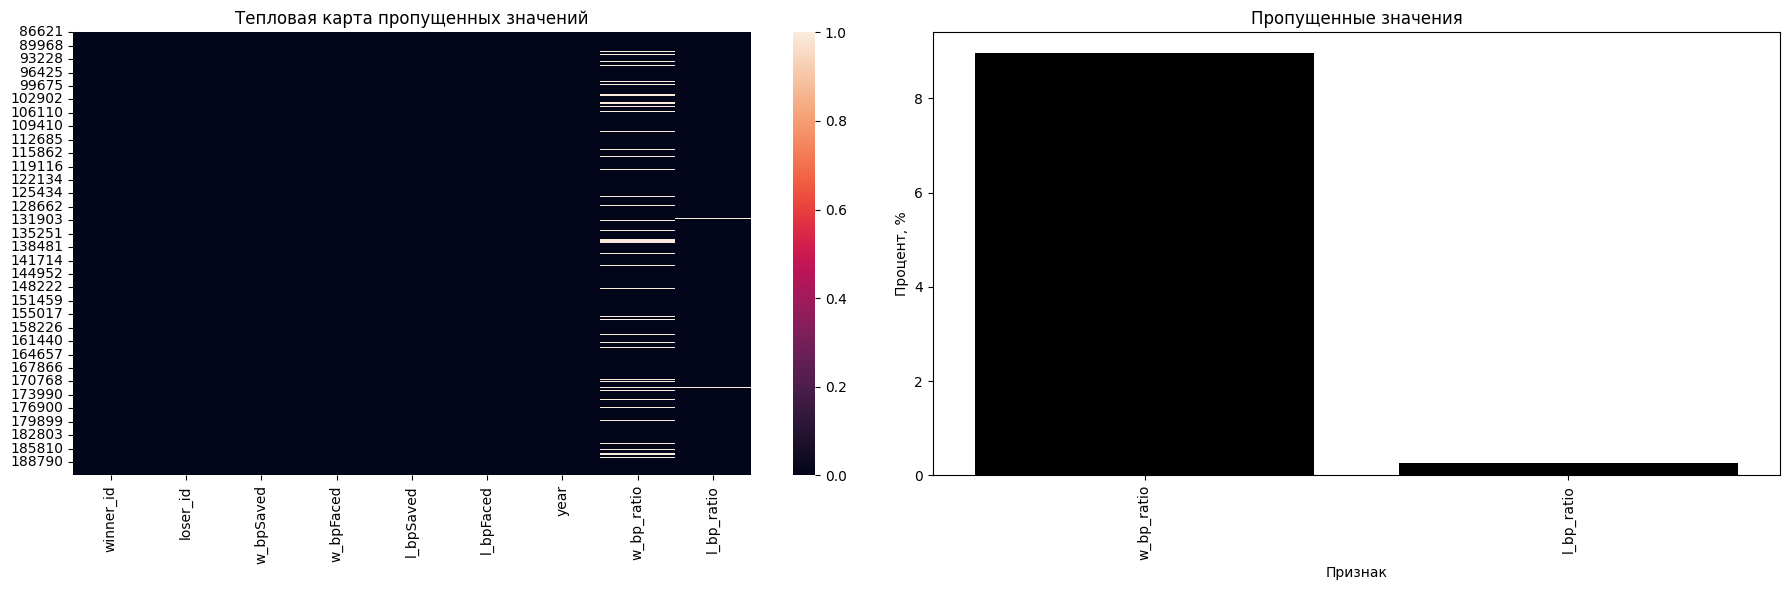

In [ ]:
# Проверяем полученную выборку data_win
data_duplicates = find_duplicates(data)
low_info_cols = check_low_information_cols(data)
check_missing_values(data)

In [ ]:
# Удаление строк с отсутствующими значениями
data = data.dropna()

# Проверяем
check_missing_values(data)

Пропущенных значений нет.


In [ ]:
# Создание признака 'median_level'
w_bp_ratio_median = data['w_bp_ratio'].median()
l_bp_ratio_median = data['l_bp_ratio'].median()

data['median_level'] = 'upper median'
data.loc[(data['w_bp_ratio'] <= w_bp_ratio_median) & (data['l_bp_ratio'] <= l_bp_ratio_median), 'median_level'] = 'under median'

# Создадим две выборки для победителей и проигравших

data_win = data[['year', 'winner_id','w_bp_ratio','median_level']]
data_win = data_win.rename(columns={'winner_id': 'player_id','w_bp_ratio':'w_bp_ratio','median_level':'median_level'})

data_loss = data[['year', 'loser_id','l_bp_ratio','median_level']]
data_loss = data_loss.rename(columns={'loser_id': 'player_id','l_bp_ratio':'l_bp_ratio','median_level':'median_level'})

In [ ]:
data_win.head()

,year,player_id,w_bp_ratio,median_level
86621,1991,101723,0.500,upper median
86622,1991,100946,0.900,upper median
86623,1991,101234,1.000,upper median
86624,1991,101889,1.000,upper median
86625,1991,101274,0.875,upper median


In [ ]:
data_loss.head()

,year,player_id,l_bp_ratio,median_level
86621,1991,101414,0.750,upper median
86622,1991,101256,0.500,upper median
86623,1991,101421,0.500,upper median
86624,1991,101703,0.625,upper median
86625,1991,101843,0.500,upper median


In [ ]:
# Добавление столбца 'result' с исходом игры
data_win['result'] = 'победа'
data_loss['result'] = 'поражение'

In [ ]:
# Объединим датафреймы в один
data_win_loss = pd.concat([data_win, data_loss], axis=0).reset_index(drop=True)
data_win_loss_grouped = data_win_loss.groupby('result')['median_level'].value_counts().unstack()

In [ ]:
data_win_loss

,year,player_id,w_bp_ratio,median_level,result,l_bp_ratio
0,1991,101723,0.500,upper median,победа,NaN
1,1991,100946,0.900,upper median,победа,NaN
2,1991,101234,1.000,upper median,победа,NaN
3,1991,101889,1.000,upper median,победа,NaN
4,1991,101274,0.875,upper median,победа,NaN
...,...,...,...,...,...,...
172715,2023,104905,NaN,upper median,поражение,0.200000
172716,2023,200711,NaN,upper median,поражение,0.571429
172717,2023,104527,NaN,under median,поражение,0.333333
172718,2023,100644,NaN,under median,поражение,0.333333


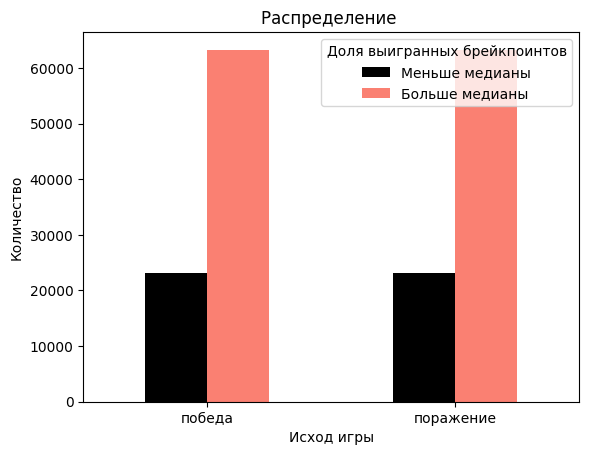

In [ ]:
# Построение столбчатой диаграммы
data_win_loss_grouped.plot(kind='bar', color=['black', 'salmon'])
plt.title('Распределение ')
plt.xlabel('Исход игры')
plt.ylabel('Количество')
plt.legend(title='Доля выигранных брейкпоинтов', labels=['Меньше медианы', 'Больше медианы'])
plt.xticks(rotation=0)  # Поворот подписей по оси X для лучшей читаемости
plt.show()

## Тест хи-квадрат
тест хи-квадрат предназначен для проверки наличия статистической связи между двумя категориальными переменными. Он используется для определения, насколько сильно переменные связаны между собой.

Применение теста хи-квадрат может быть обосновано в следующих случаях:
1. Когда у нас есть две категориальные переменные и мы хотим определить, существует ли статистическая связь между ними.
2. Когда нам нужно определить, насколько наблюдаемые частоты отличаются от ожидаемых частот в случае отсутствия связи между переменными.

Использование теста хи-квадрат позволяет оценить статистическую значимость связи между переменными и проверить гипотезу о их независимости. Таким образом, данный тест может быть полезен для анализа взаимосвязи между двумя категориальными переменными в исследовании или наборе данных.

[ссылка на документацию](https://https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html)

`H0` - Распределения по годам независимы для всех игроков

`H1` - Распределения по годам зависимы хотя бы для одного игрока

In [ ]:
# @title Проверка гипотезы о независимости

# Вычисляем результат теста для каждой пары столбцов
result1 = chi2_contingency(data_win_loss_grouped['under median'])
result2 = chi2_contingency(data_win_loss_grouped['upper median'])

# Определяем уровень значимости
alpha = 0.05

# Сравниваем полученное p-value с уровнем значимости
if (result1.pvalue < alpha) and (result2.pvalue < alpha) :
    print('Принимаем нулевую гипотезу H0')
else:
    print('Отвергаем нулевую гипотезу H0')
    print('Принимаем альтернативную гипотезу H1')

Отвергаем нулевую гипотезу H0
Принимаем альтернативную гипотезу H1
